## 1) Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient


## 2) Config and Paths

In [25]:
RAW_DATA_PATH = Path("/Users/sriks/Documents/Projects/MLOps_Submissions/Labs/Lab_8/Experiment_Tracking_Labs/MLFlow_Lab/Data/raw/pizza_sales.csv")
PROCESSED_DIR = Path("/Users/sriks/Documents/Projects/MLOps_Submissions/Labs/Lab_8/Experiment_Tracking_Labs/MLFlow_Lab/Data/processed")
OUTPUTS_DIR = Path("/Users/sriks/Documents/Projects/MLOps_Submissions/Labs/Lab_8/Experiment_Tracking_Labs/MLFlow_Lab/outputs")
EDA_DIR = OUTPUTS_DIR / "eda_plots"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
EDA_DIR.mkdir(parents=True, exist_ok=True)

EXPERIMENT_NAME = "pizza_sales_daily_revenue"
MODEL_NAME = "pizza_sales_regressor"

mlflow.set_experiment(EXPERIMENT_NAME)


<Experiment: artifact_location='file:///Users/sriks/Documents/Projects/MLOps_Submissions/Labs/Lab_8/Experiment_Tracking_Labs/MLFlow_Lab/Notebooks/mlruns/978991350720744069', creation_time=1761165076914, experiment_id='978991350720744069', last_update_time=1761165076914, lifecycle_stage='active', name='pizza_sales_daily_revenue', tags={}>

## 3) Load Dataset

In [14]:
data = pd.read_csv(RAW_DATA_PATH)
print(data.shape)
data.head()


(48620, 12)


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


## 4) Initial Inspection

In [15]:
data.info()
data.describe(include='all').T.head(20)
data.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  float64
 1   order_id           48620 non-null  float64
 2   pizza_name_id      48620 non-null  object 
 3   quantity           48620 non-null  float64
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48620 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48620 non-null  object 
 10  pizza_ingredients  48620 non-null  object 
 11  pizza_name         48620 non-null  object 
dtypes: float64(5), object(7)
memory usage: 4.5+ MB


pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

## 5) Data Cleaning

In [17]:
data.columns = [c.strip().lower().replace(" ", "_") for c in data.columns]

data['order_date'] = pd.to_datetime(data['order_date'], errors='coerce')
data['order_time'] = pd.to_datetime(data['order_time'], errors='coerce').dt.time

for col in ['quantity', 'unit_price', 'total_price']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

critical_cols = ['order_id', 'order_date', 'total_price']
data = data.dropna(subset=[c for c in critical_cols if c in data.columns])

data.head(3)


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza


## 6) Feature Engineering

In [18]:
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month
data['day'] = data['order_date'].dt.day
data['weekday'] = data['order_date'].dt.day_name()
data['is_weekend'] = data['weekday'].isin(['Saturday','Sunday']).astype(int)

for cat_col in ['pizza_size', 'pizza_category']:
    if cat_col in data.columns:
        data[cat_col] = data[cat_col].astype('category')

data.head(3)


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,year,month,day,weekday,is_weekend
0,1.0,1.0,hawaiian_m,1.0,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015,1,1,Thursday,0
1,2.0,2.0,classic_dlx_m,1.0,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015,1,1,Thursday,0
2,3.0,2.0,five_cheese_l,1.0,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015,1,1,Thursday,0


## 7) Exploratory Data Analysis (EDA)

### 7.1 Daily Revenue Trend

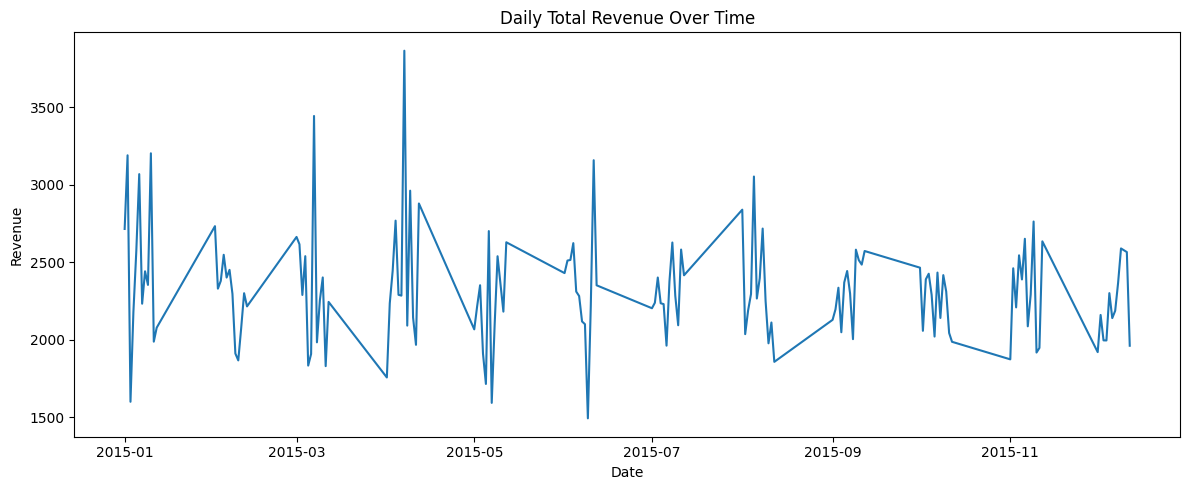

In [19]:
daily_sales = data.groupby('order_date', as_index=False)['total_price'].sum().rename(columns={'total_price':'daily_revenue'})
plt.figure(figsize=(12,5))
plt.plot(daily_sales['order_date'], daily_sales['daily_revenue'])
plt.title("Daily Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(EDA_DIR / 'sales_trend.png')
plt.show()


### 7.2 Top Pizzas by Revenue


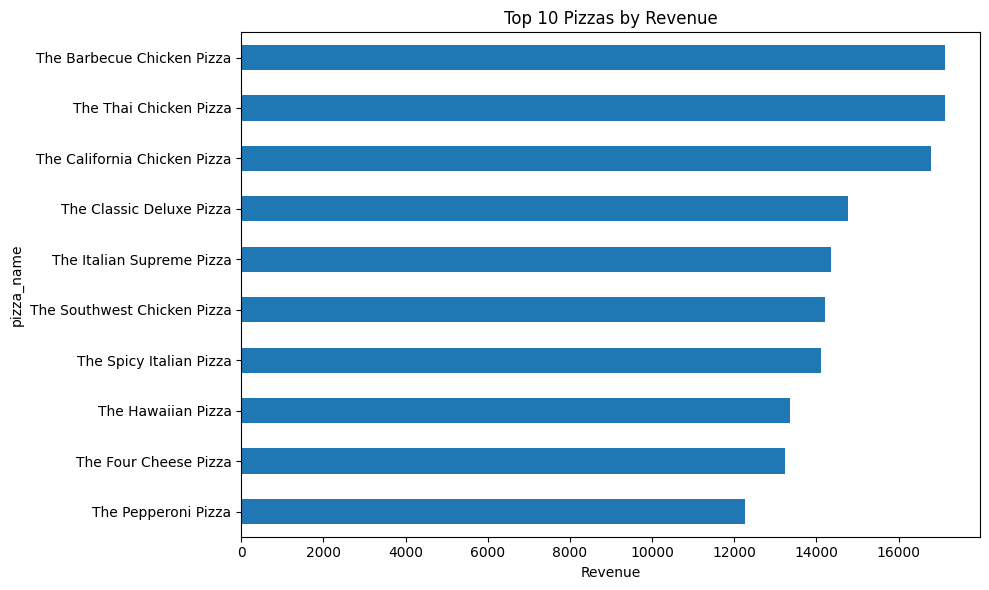

In [20]:
top_pizzas = data.groupby('pizza_name')['total_price'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
top_pizzas[::-1].plot(kind='barh')
plt.title("Top 10 Pizzas by Revenue")
plt.xlabel("Revenue")
plt.tight_layout()
plt.savefig(EDA_DIR / 'top_pizzas.png')
plt.show()


### 7.3 Revenue by Weekday

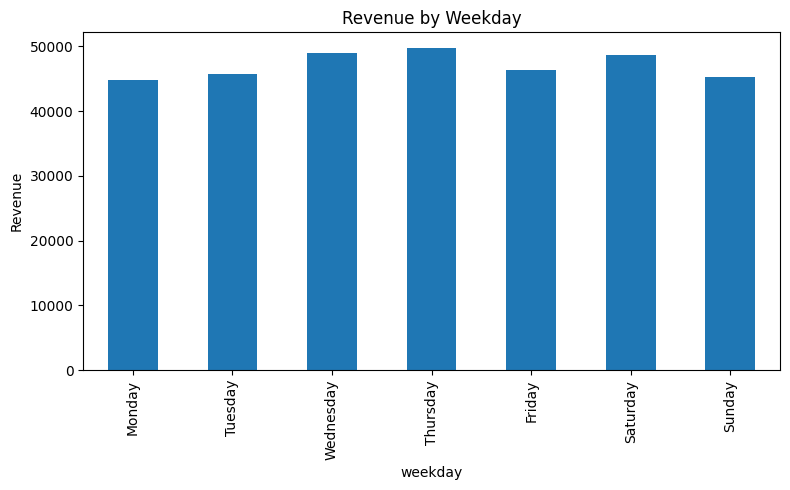

In [21]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
wk = data.groupby('weekday')['total_price'].sum().reindex(weekday_order)
plt.figure(figsize=(8,5))
wk.plot(kind='bar')
plt.title("Revenue by Weekday")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig(EDA_DIR / 'weekday_sales.png')
plt.show()


### 7.4 Size vs Revenue

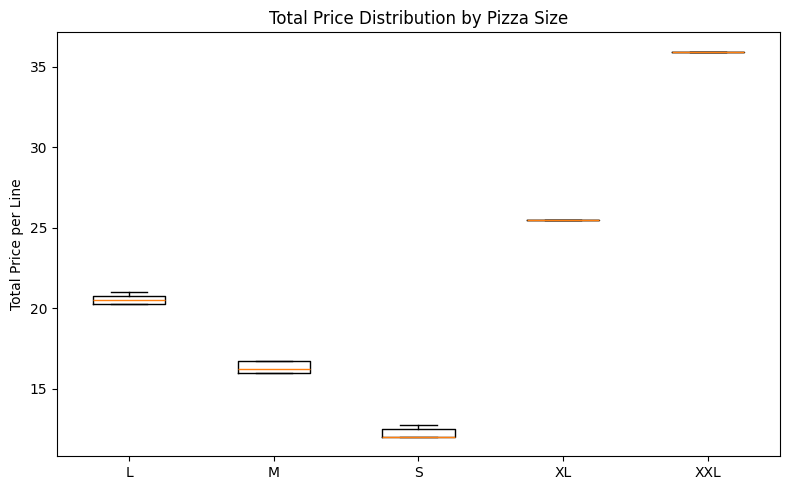

In [22]:
sizes = [grp['total_price'].values for _, grp in data.groupby('pizza_size')]
labels = [str(k) for k, _ in data.groupby('pizza_size')]
plt.figure(figsize=(8,5))
plt.boxplot(sizes, labels=labels, showfliers=False)
plt.title("Total Price Distribution by Pizza Size")
plt.ylabel("Total Price per Line")
plt.tight_layout()
plt.savefig(EDA_DIR / 'size_vs_revenue.png')
plt.show()


## 8) Aggregate to Daily Revenue

In [23]:
daily = (data.groupby('order_date', as_index=False)
         .agg(daily_revenue=('total_price','sum'),
              orders=('order_id','nunique'),
              lines=('order_id','size')))

daily['year'] = daily['order_date'].dt.year
daily['month'] = daily['order_date'].dt.month
daily['day'] = daily['order_date'].dt.day
daily['weekday'] = daily['order_date'].dt.day_name()
daily['is_weekend'] = daily['weekday'].isin(['Saturday','Sunday']).astype(int)

daily.to_csv(PROCESSED_DIR / 'daily_sales.csv', index=False)
daily.head()


,order_date,daily_revenue,orders,lines,year,month,day,weekday,is_weekend
0,2015-01-01,2713.85,69,161,2015,1,1,Thursday,0
1,2015-01-02,3189.20,87,188,2015,1,2,Friday,0
2,2015-01-03,1598.55,49,99,2015,1,3,Saturday,1
3,2015-01-04,2176.85,67,133,2015,1,4,Sunday,1
4,2015-01-05,2571.95,75,152,2015,1,5,Monday,0


## 9) Train-Test Split

In [38]:
feature_cols = ['orders','lines','year','month','day','is_weekend']
weekday_dummies = pd.get_dummies(daily['weekday'], prefix='wd', drop_first=True)
X = pd.concat([daily[feature_cols], weekday_dummies], axis=1)
y = daily['daily_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


## 10) Baseline Model Training with MLflow

In [39]:
with mlflow.start_run(run_name="rf_baseline_daily_revenue"):
    params = {"n_estimators": 200, "max_depth": 8, "random_state": 123}
    mlflow.log_params(params)

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    importances.to_csv(OUTPUTS_DIR / "feature_importance.csv")
    mlflow.log_artifact(str(OUTPUTS_DIR / "feature_importance.csv"))

    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)

    metrics = {"rmse": float(rmse), "r2": float(r2)}
    pd.Series(metrics).to_json(OUTPUTS_DIR / "metrics.json")
    mlflow.log_artifact(str(OUTPUTS_DIR / "metrics.json"))

    print(f"RMSE: {rmse:.2f}  R2: {r2:.3f}")


2025/10/22 17:24:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RMSE: 124.38  R2: 0.910


## 11) Register Model in MLflow Model Registry

In [45]:
# --- PATCH: fix RepresenterError in MLflow 3.x model registry ---
import yaml
from yaml.representer import SafeRepresenter
import mlflow.utils.yaml_utils as yaml_utils

def _safe_represent_any(representer, data):
    """Force non-serializable objects (like Metric) to strings."""
    return representer.represent_str(str(data))

yaml.add_representer(object, _safe_represent_any, Dumper=yaml.SafeDumper)
yaml_utils.yaml.add_representer(object, _safe_represent_any, Dumper=yaml_utils.yaml.SafeDumper)
# --- END PATCH ---


In [46]:
import mlflow
from mlflow.tracking import MlflowClient

EXPERIMENT_NAME = "Pizza_Sales_Experiment"
MODEL_NAME = "pizza_sales_regressor"

client = MlflowClient()

exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if exp is None:
    mlflow.set_experiment(EXPERIMENT_NAME)
    exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

runs = client.search_runs(exp.experiment_id, order_by=["attributes.start_time DESC"], max_results=1)
if not runs:
    raise ValueError(f"No runs found for experiment '{EXPERIMENT_NAME}'.")

best_run = runs[0]
best_run_id = best_run.info.run_id
print("Using run:", best_run_id)

model_uri = f"runs:/{best_run_id}/model"
reg = mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)

# Description (safe after patch)
client.update_model_version(
    name=MODEL_NAME,
    version=reg.version,
    description="Best performing pizza sales regression model."
)

# Transition to Production
client.transition_model_version_stage(
    name=MODEL_NAME,
    version=reg.version,
    stage="Production",
    archive_existing_versions=True
)

print("✅ Model successfully promoted to Production.")


Registered model 'pizza_sales_regressor' already exists. Creating a new version of this model...
2025/10/22 17:51:45 WARNING mlflow.tracking._model_registry.fluent: Run with id 6baff95028864a3d976cd1f63af702da has no artifacts at artifact path 'model', registering model based on models:/m-58362125fa574d9da8a61b8bae135f2d instead


Using run: 6baff95028864a3d976cd1f63af702da


Created version '14' of model 'pizza_sales_regressor'.


RepresenterError: ('cannot represent an object', <Metric: dataset_digest=None, dataset_name=None, key='r2', model_id='m-58362125fa574d9da8a61b8bae135f2d', run_id='6baff95028864a3d976cd1f63af702da', step=0, timestamp=1761168291349, value=0.9096788974485339>)

## 12) Load Production Model and Predict

In [ ]:
prod_model = mlflow.sklearn.load_model(f"models:/{MODEL_NAME}/Production")
test_preds = prod_model.predict(X_test)
print("Sample predictions:", test_preds[:5])
print("Test RMSE:", mean_squared_error(y_test, test_preds, squared=False))
print("Test R2:", r2_score(y_test, test_preds))


## 13) Optional — Serve the Production Model

In [ ]:
mlflow models serve -m models:/pizza_sales_regressor/Production -h 0.0.0.0 -p 5001
